# Experiment 2-1: Binary Logistic Regression on Iris Dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression
#from models.hyperplane_clf import SmoothedSupportVector

In [4]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=0.2)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

80 4


## Fit Model

In [5]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)

In [15]:
tf.reset_default_graph()
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 0.65617335 (0.048 sec)
Step 1000, Epoch 375: loss = 0.04787267 (0.001 sec)
Step 2000, Epoch 750: loss = 0.02834478 (0.001 sec)
Step 3000, Epoch 1125: loss = 0.02570353 (0.001 sec)
Step 4000, Epoch 1500: loss = 0.01754167 (0.001 sec)
Step 5000, Epoch 1875: loss = 0.01529602 (0.001 sec)
Step 6000, Epoch 2250: loss = 0.01410864 (0.001 sec)
Step 7000, Epoch 2625: loss = 0.03226178 (0.001 sec)
Step 8000, Epoch 3000: loss = 0.01363071 (0.001 sec)
Step 9000, Epoch 3375: loss = 0.02662032 (0.001 sec)
Step 10000, Epoch 3750: loss = 0.00584569 (0.001 sec)
Step 11000, Epoch 4125: loss = 0.01076576 (0.001 sec)
Step 12000, Epoch 4500: loss = 0.01134654 (0.001 sec)
Step 13000, Epoch 4875: loss = 0.03102768 (0.002 sec)
Step 14000, Epoch 5250: loss = 0.02361450 (0.001 sec)
Step 15000, Epoch 5625: loss = 0.02707568 (0.001 sec)
Step 16000, Epoch 6000: loss = 0.01384364 (0.001 sec)
Step 17000, Epoch 6375: loss = 0.02733575 (0.001 sec)
Step 18000, Epoch 6750: loss = 0.01858595 (0.0

BinaryLogistic-Notebook(init_eta=0.1,batch_size=30,decay_epochs=(2000, 4000),C=1.0)

## Fit with Skearn

In [6]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.422830
Norm of Params: 4.106604
Norm of Gradient: 0.051333


BinaryLogistic-Notebook(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1.0)

In [7]:
model.get_eval(items=['params_flat'])

array([[ 1.5956767],
       [ 1.8466895],
       [-2.3730352],
       [-2.2970529]], dtype=float32)

## Predicitons (Not Important)

In [8]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/n_te)

Train accuracy: 0.9875
Test accuracy: 0.85


## Calculate I_loss

In [9]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (0.102 sec)


In [10]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)

Fetch training loss gradients (0.036 sec)
         Current function value: -0.956071
         Iterations: 6
         Function evaluations: 20
         Gradient evaluations: 25
         Hessian evaluations: 17
         Current function value: -0.107540
         Iterations: 5
         Function evaluations: 98
         Gradient evaluations: 93
         Hessian evaluations: 13
         Current function value: -0.120165
         Iterations: 4
         Function evaluations: 65
         Gradient evaluations: 58
         Hessian evaluations: 13
         Current function value: -0.074743
         Iterations: 5
         Function evaluations: 93
         Gradient evaluations: 87
         Hessian evaluations: 15
Optimization terminated successfully.
         Current function value: -0.227125
         Iterations: 6
         Function evaluations: 35
         Gradient evaluations: 40
         Hessian evaluations: 17
         Current function value: -0.254381
         Iterations: 4
         Function e

## Run LOO

In [11]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 0.42400235 (0.018 sec)
LOO Fold 8: loss = 0.41924122 (0.007 sec)
LOO Fold 16: loss = 0.42120889 (0.003 sec)
LOO Fold 24: loss = 0.41813612 (0.004 sec)
LOO Fold 32: loss = 0.42299604 (0.004 sec)
LOO Fold 40: loss = 0.42311153 (0.003 sec)
LOO Fold 48: loss = 0.42221051 (0.003 sec)
LOO Fold 56: loss = 0.42032817 (0.003 sec)
LOO Fold 64: loss = 0.42256388 (0.004 sec)
LOO Fold 72: loss = 0.42361739 (0.004 sec)


## Compare LOO and I_loss

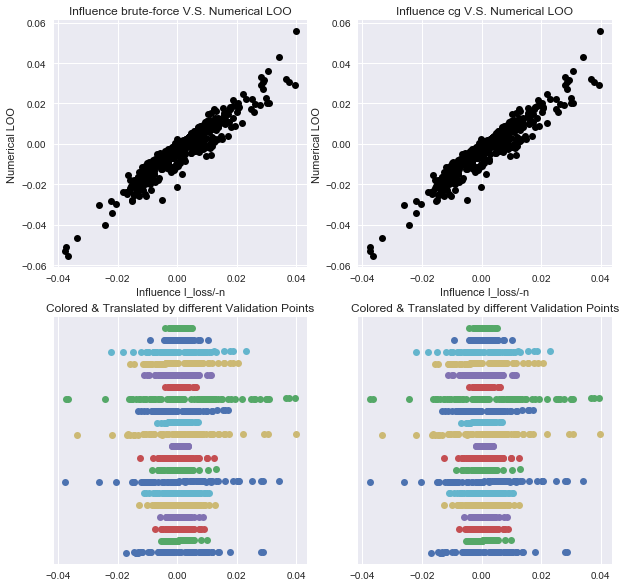

In [12]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,:],
     I_loss_cg[:,:]],
    loo_diff, n_samples=n_tr
)

In [ ]:
# leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

In [13]:
# without leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_cg[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_cg[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9887
Test Point 1 Correlation: 0.9882
Test Point 2 Correlation: 0.9946
Test Point 3 Correlation: 0.9905
Test Point 4 Correlation: 0.9992
Test Point 5 Correlation: 0.9934
Test Point 6 Correlation: 0.9719
Test Point 7 Correlation: 0.9747
Test Point 8 Correlation: 0.9653
Test Point 9 Correlation: 0.9720
Test Point 10 Correlation: 0.9564
Test Point 11 Correlation: 0.9778
Test Point 12 Correlation: 0.9902
Test Point 13 Correlation: 0.9909
Test Point 14 Correlation: 0.9904
Test Point 15 Correlation: 0.9781
Test Point 16 Correlation: 0.9946
Test Point 17 Correlation: 0.9959
Test Point 18 Correlation: 0.9603
Test Point 19 Correlation: 0.9706
Overall Correlation: 0.9345


# Experiment 2-2: Binary Logistic Regression on MNIST

In [31]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.BinaryMNIST17, test_config=10)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = np.random.choice(n_tr, size=150, replace=False)

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

9075 784


In [34]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=10000.0
)

In [35]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.006013
Norm of Params: 0.061819
Norm of Gradient: 0.068123


BinaryLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=10000.0)

In [36]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/n_te)

Train accuracy: 1.0
Test accuracy: 1.0


In [37]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)

Fetch training loss gradients (4.920 sec)


In [38]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (4.635 sec)
Optimization terminated successfully.
         Current function value: -0.001805
         Iterations: 11
         Function evaluations: 65
         Gradient evaluations: 73
         Hessian evaluations: 107
Optimization terminated successfully.
         Current function value: -0.002051
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 27
         Hessian evaluations: 98
Optimization terminated successfully.
         Current function value: -0.001750
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 28
         Hessian evaluations: 110
Optimization terminated successfully.
         Current function value: -0.001786
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 96
Optimization terminated successfully.
         Current function value: -0.001801
         Iterations: 10
         Function evaluatio

In [39]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 0.00601333 (0.147 sec)
LOO Fold 15: loss = 0.00601333 (0.101 sec)
LOO Fold 30: loss = 0.00601331 (0.096 sec)
LOO Fold 45: loss = 0.00601332 (0.096 sec)
LOO Fold 60: loss = 0.00601330 (0.099 sec)
LOO Fold 75: loss = 0.00601331 (0.095 sec)
LOO Fold 90: loss = 0.00601331 (0.098 sec)
LOO Fold 105: loss = 0.00601315 (0.207 sec)
LOO Fold 120: loss = 0.00601332 (0.097 sec)
LOO Fold 135: loss = 0.00601332 (0.090 sec)


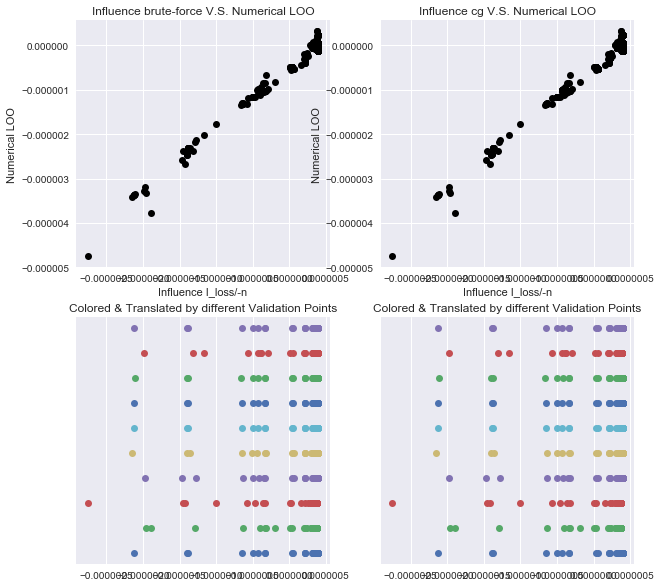

In [40]:
fig, axes = compare_with_loo(
    [I_loss_bf[leave_indices,:],
     I_loss_cg[leave_indices,:]],
    loo_diff, n_samples=n_tr
)

In [ ]:
# 终于特么做出来了

In [42]:
# leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9917
Test Point 1 Correlation: 0.9876
Test Point 2 Correlation: 0.9920
Test Point 3 Correlation: 0.9914
Test Point 4 Correlation: 0.9918
Test Point 5 Correlation: 0.9917
Test Point 6 Correlation: 0.9917
Test Point 7 Correlation: 0.9918
Test Point 8 Correlation: 0.9909
Test Point 9 Correlation: 0.9917
Overall Correlation: 0.9896
